In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import math
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, PowerTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

In [3]:
df = pd.read_csv("./ST1511-CA2-data/Company_Employee.csv")
df.head()

,Age,Gender,BusinessTravel,Job Function,Distance Between Company and Home (KM),"Education (1 is lowest, 5 is highest)","Job Satisfaction (1 is lowest, 4 is highest)",MaritalStatus,Salary ($),"Performance Rating (1 is lowest, 4 is highest)","Work Life Balance (1 is worst, 4 is best)",Length of Service (Years),Resign Status
0,41,Female,Travel_Rarely,Sales,1,2,4,Single,5993,3,1,6,Yes
1,49,Male,Travel_Frequently,Research & Development,8,1,2,Married,5130,4,3,10,No
2,37,Male,Travel_Rarely,Research & Development,2,2,3,Single,2090,3,3,0,Yes
3,33,Female,Travel_Frequently,Research & Development,3,4,3,Married,2909,3,3,8,No
4,27,Male,Travel_Rarely,Research & Development,2,1,2,Married,3468,3,3,2,No


In [4]:
# sns.pairplot(df.select_dtypes(include=np.number), height=4)
# plt.show()

In [5]:
df_log = df.copy()
df_log[['Salary ($)', 'Distance Between Company and Home (KM)', 'Length of Service (Years)']] = np.log(df_log[['Salary ($)', 'Distance Between Company and Home (KM)', 'Length of Service (Years)']]+0.1)
df_log = df_log.drop(['Resign Status'], axis=1)

In [6]:
def calculate_zscore(df, columns):
  '''
  scales columns in dataframe using z-score
  '''
  df = df.copy()
  for col in columns:
      df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)

  return df



def one_hot_encode(df, columns):
  '''
  one hot encodes list of columns and
  concatenates them to the original df
  '''

  concat_df = pd.concat([pd.get_dummies(df[col], drop_first=True, prefix=col) for col in columns], axis=1)
  one_hot_cols = concat_df.columns

  return concat_df, one_hot_cols



def normalize_column_modality(df, columns):
  '''
  divides each column by the probability μₘ of the modality 
  (number of ones in the column divided by N) only for one hot columns
  '''

  length = len(df)
  for col in columns:
    
    weight = math.sqrt(sum(df[col])/length)
    df[col] = df[col]/weight

  return df



def center_columns(df, columns):
  '''
  center columns by subtracting the mean value
  '''
  for col in columns:
      df[col] = (df[col] - df[col].mean())

  return df



def FAMD_(df, n_components=2):
  '''
  Factorial Analysis of Mixed Data (FAMD), 
  which generalizes the Principal Component Analysis (PCA) 
  algorithm to datasets containing numerical and categorical variables
  a) For the numerical variables
    - Standard scale (= get the z-score)
  
  b) For the categorical variables:
    - Get the one-hot encoded columns
    - Divide each column by the square root of its probability sqrt(μₘ)
    - Center the columns
  c) Apply a PCA algorithm over the table obtained!
  '''
  
  numeric_cols = df.select_dtypes(include=np.number)
  cat_cols = df.select_dtypes(include='object')
  
  # numeric process
  normalized_df = calculate_zscore(df, numeric_cols)
  normalized_df = normalized_df[numeric_cols.columns]

  # categorical process
  cat_one_hot_df, one_hot_cols = one_hot_encode(df, cat_cols)
  cat_one_hot_norm_df = normalize_column_modality(cat_one_hot_df, one_hot_cols)
  cat_one_hot_norm_center_df = center_columns(cat_one_hot_norm_df, one_hot_cols)

  # Merge DataFrames
  processed_df = pd.concat([normalized_df, cat_one_hot_norm_center_df], axis=1)

  # Perform (PCA)
  pca = PCA(n_components=n_components)
  principalComponents = pca.fit_transform(processed_df)

  return pca, principalComponents, processed_df


pca, FAMD_components, processed_df = FAMD_(df_log, n_components=None)

<Figure size 1800x576 with 0 Axes>

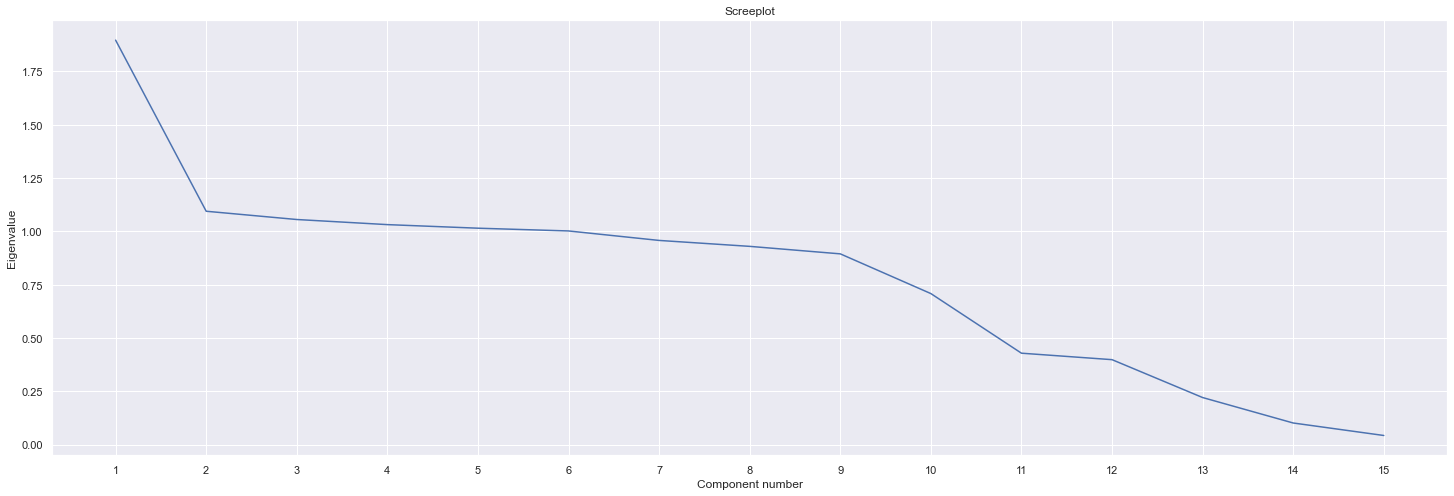

In [7]:
sns.set(rc={'figure.figsize':(25,8)})
#Scree plot
import matplotlib.ticker as ticker
plt.clf()
fig1, ax1 = plt.subplots()
ax1.plot(np.arange(1, len(pca.explained_variance_)+1), pca.explained_variance_)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set(xlabel = 'Component number', ylabel = 'Eigenvalue', title = 'Screeplot')
plt.show()

In [8]:
# Computes the PCs and percentage variance explained
# Pass original data and returns of PCA to this function.
# This function returns a table summarising the eigenvalues, % variance explained, cumulative % variance explained and PCs
# Dimension indexing
dimensions = ['PC {}'.format(i) for i in range(1,len(pca.components_)+1)]

# PCA components
components = pd.DataFrame(np.round(pca.components_, 4), columns=processed_df.columns)
components.index = dimensions

#PCA eigenvalues
ev = pca.explained_variance_.reshape(len(pca.components_), 1)
eigenvalues = pd.DataFrame(np.round(ev, 4), columns = ['Eigenvalue']) 
eigenvalues.index = dimensions

# PCA explained variance
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
variance_ratios.index = dimensions

# PCA cumulative variance
cum_ratios = np.cumsum(ratios)
variance_cum_ratios = pd.DataFrame(np.round(cum_ratios, 4), columns = ['Cumulative Explained Variance'])
variance_cum_ratios.index = dimensions

# Return a concatenated DataFrame
pca_results = pd.concat([eigenvalues, variance_ratios, variance_cum_ratios, components], axis = 1)
pca_results

,Eigenvalue,Explained Variance,Cumulative Explained Variance,Age,Distance Between Company and Home (KM),"Education (1 is lowest, 5 is highest)","Job Satisfaction (1 is lowest, 4 is highest)",Salary ($),"Performance Rating (1 is lowest, 4 is highest)","Work Life Balance (1 is worst, 4 is best)",Length of Service (Years),Gender_Male,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Job Function_Research & Development,Job Function_Sales,MaritalStatus_Married,MaritalStatus_Single
PC 1,1.8970,0.1611,0.1611,-0.5469,0.0038,-0.2401,0.0085,-0.6029,0.0206,-0.0194,-0.4824,0.0293,0.0370,-0.0234,0.0515,-0.0711,-0.1088,0.1544
PC 2,1.0943,0.0929,0.2540,-0.1280,-0.0451,0.0620,0.0793,0.1092,-0.2466,0.5467,-0.0250,-0.0209,0.1538,-0.0826,-0.3772,0.5527,-0.2092,0.2770
PC 3,1.0556,0.0896,0.3437,0.0659,-0.3938,-0.0579,0.5291,0.0338,0.2990,-0.0555,0.1165,-0.0044,0.5263,-0.2753,0.1151,-0.1600,-0.1594,0.1816
PC 4,1.0316,0.0876,0.4313,-0.1727,0.2681,-0.6043,0.0356,0.0657,0.4528,0.1992,0.2353,-0.0004,0.0785,-0.0423,-0.1306,0.1866,0.2640,-0.3130
PC 5,1.0149,0.0862,0.5175,0.0418,-0.6118,-0.0654,-0.5246,-0.0057,0.2266,0.4799,-0.0121,-0.0193,-0.0669,0.0405,0.1232,-0.1987,0.0233,-0.0301
PC 6,1.0019,0.0851,0.6026,0.0662,0.4977,0.4462,-0.3196,-0.0530,0.5175,0.1296,-0.0922,-0.0248,0.2760,-0.1487,0.0367,-0.0513,-0.1433,0.1653
PC 7,0.9575,0.0813,0.6839,0.0360,-0.0713,0.1399,0.4159,0.0046,0.4970,0.0987,-0.0842,0.0097,-0.6171,0.3087,-0.0552,0.0858,-0.1288,0.1846
PC 8,0.9296,0.0789,0.7628,-0.0171,-0.1658,-0.2727,-0.3999,0.1465,0.1909,-0.5733,0.1092,-0.0463,-0.0302,0.0178,-0.1844,0.2888,-0.3005,0.3584
PC 9,0.8945,0.0760,0.8388,0.0053,-0.3258,0.3583,-0.0035,-0.1181,0.2010,-0.2592,-0.3063,0.0006,0.1291,-0.0646,-0.2755,0.3968,0.3700,-0.3988
PC 10,0.7081,0.0601,0.8989,0.5894,0.0997,-0.3711,0.0247,0.1740,-0.0078,0.0590,-0.6817,0.0117,0.0562,-0.0267,-0.0019,0.0094,-0.0244,0.0332


<AxesSubplot:>

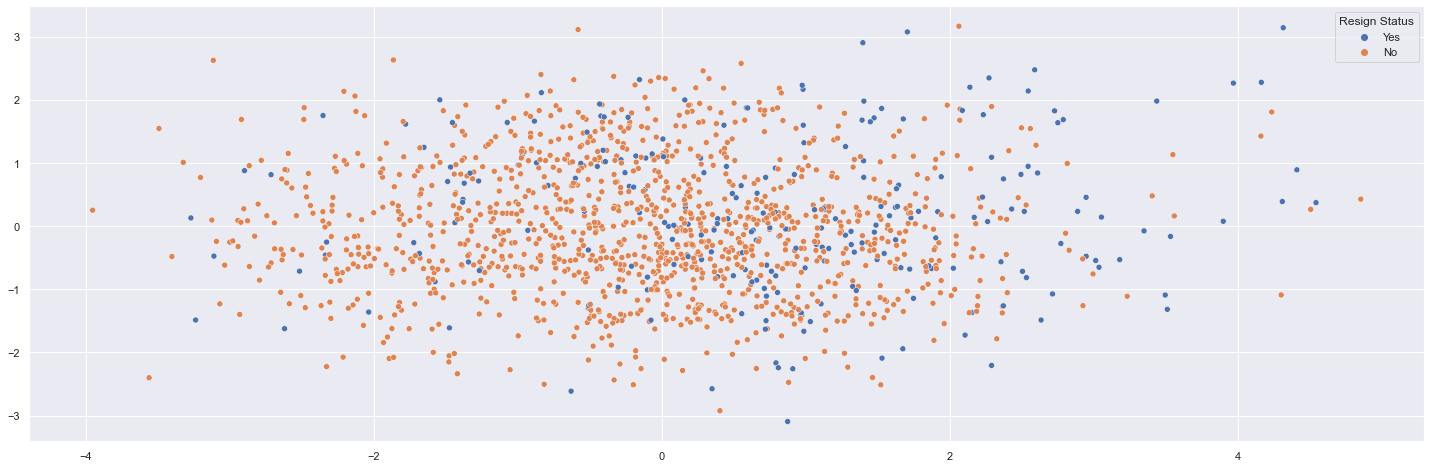

In [9]:
sns.scatterplot(x=FAMD_components[:,0], y=FAMD_components[:,1], hue=df['Resign Status'])

In [10]:
px.scatter_3d(x=FAMD_components[:,0], y=FAMD_components[:,1], z=FAMD_components[:,2], color=df['Resign Status'])

For n_clusters=2, the silhouette coefficient is: 0.11267088297537856
For n_clusters=3, the silhouette coefficient is: 0.12573977003104542
For n_clusters=4, the silhouette coefficient is: 0.12915512992514325
For n_clusters=5, the silhouette coefficient is: 0.1277951157205925
For n_clusters=6, the silhouette coefficient is: 0.12098153352297777
For n_clusters=7, the silhouette coefficient is: 0.11162355219315362
For n_clusters=8, the silhouette coefficient is: 0.10736982632120418
For n_clusters=9, the silhouette coefficient is: 0.10156253545440252
For n_clusters=10, the silhouette coefficient is: 0.10644779473723517
For n_clusters=11, the silhouette coefficient is: 0.11172710696300887
For n_clusters=12, the silhouette coefficient is: 0.11054721143490431
For n_clusters=13, the silhouette coefficient is: 0.11297643098516415
For n_clusters=14, the silhouette coefficient is: 0.11344966809128712
For n_clusters=15, the silhouette coefficient is: 0.12451466168254657
For n_clusters=16, the silhou

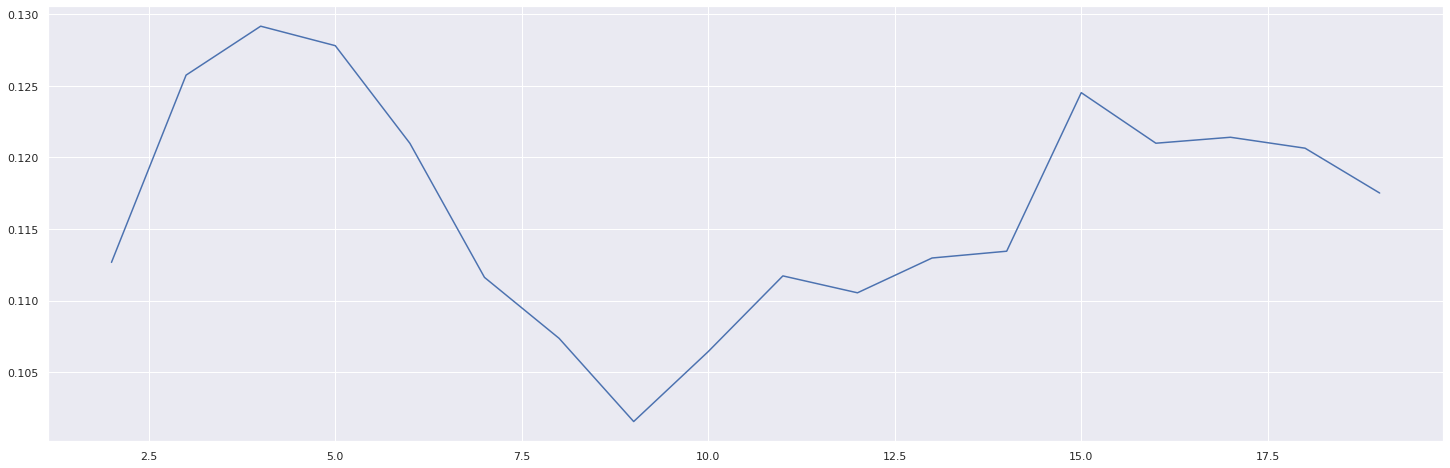

In [675]:
sils = []
ns = list(range(2,20))
for n in ns:
    model = KMeans(n_clusters=n).fit(FAMD_components[:,:9])
    label = model.labels_
    sil_coef = silhouette_score(FAMD_components[:,:9], label)
    sils.append(sil_coef)
    print(f"For n_clusters={n}, the silhouette coefficient is: {sil_coef}")

sns.lineplot(y=sils, x=ns)
plt.show()

In [727]:
n_clusters = 15

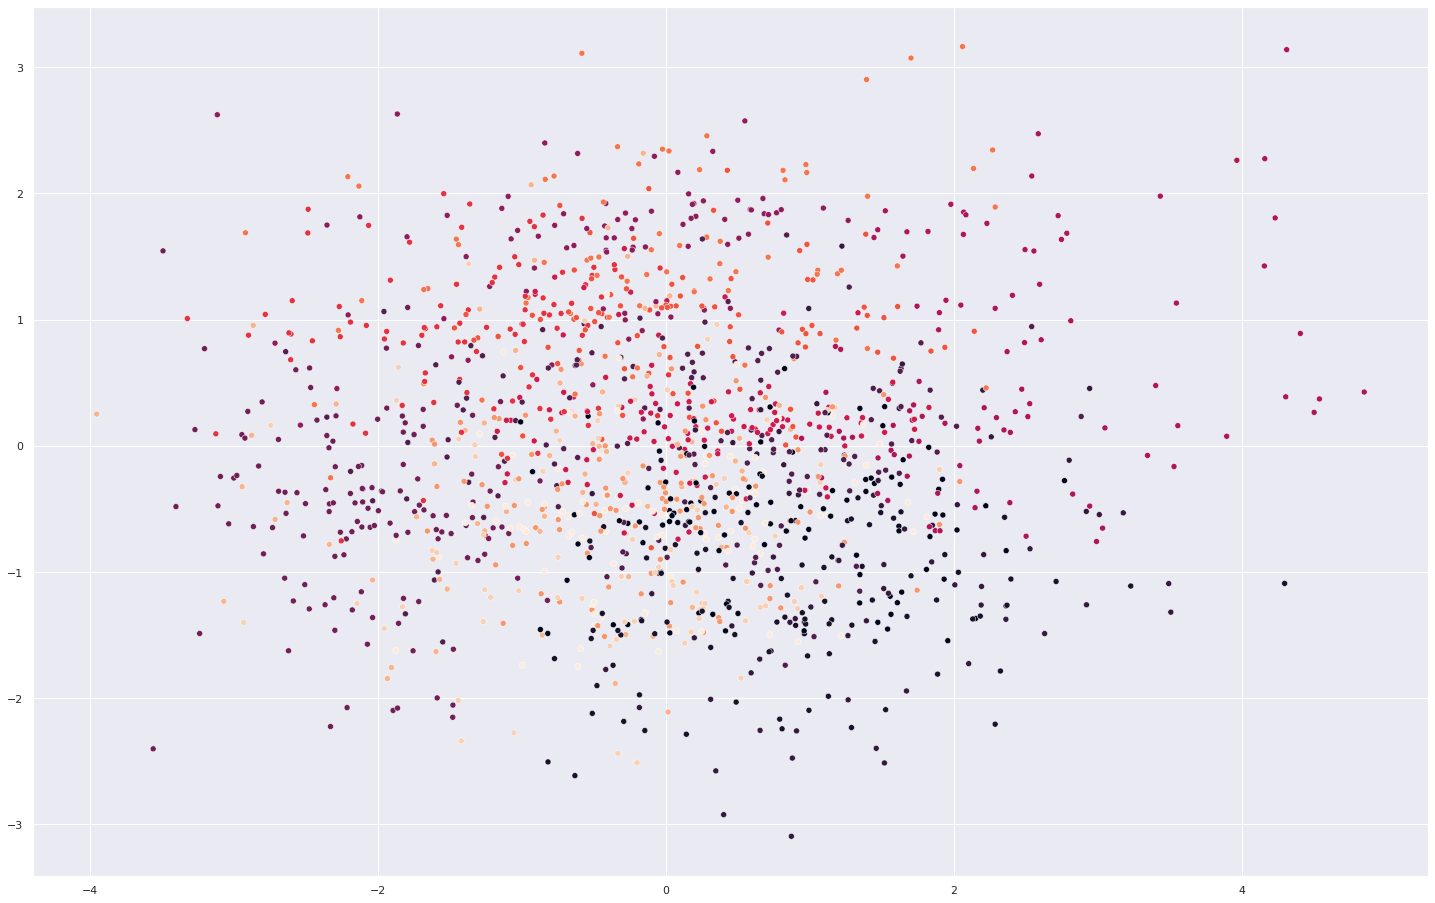

In [728]:
model = KMeans(n_clusters=n_clusters).fit(FAMD_components[:,:9])
labels = model.labels_

sns.scatterplot(x=FAMD_components[:,0], y=FAMD_components[:,1], c=labels)

In [720]:
def loadingplot(columns, pca, axis1, axis2, width=5, height=5, ymargin=0.5, xmargin=0.5):

    fig, ax = plt.subplots(figsize = (width,height))

    #Set limits for figure
    x_min = min(pca.components_[axis1,:].min(),0)-xmargin
    x_max = max(pca.components_[axis1,:].max(),0)+xmargin
    y_min = min(pca.components_[axis2,:].min(),0)-ymargin
    y_max = max(pca.components_[axis2,:].max(),0)+ymargin

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    #Scaling factor for text position
    text_pos = 0.1

    for i, v in enumerate(pca.components_.T):
        ax.arrow(0, 0, v[axis1], v[axis2], head_width=0.02, head_length=0.02, linewidth=1, color='red')
        ax.text(v[axis1], v[axis2]+text_pos, columns[i], color='black', ha='center', va='center', fontsize=8)

    plt.plot([x_min, x_max], [0, 0], color='k', linestyle='--', linewidth=1)
    plt.plot([0, 0], [y_min, y_max], color='k', linestyle='--', linewidth=1)
    ax.set_xlabel("PC"+str(axis1+1), fontsize=14)
    ax.set_ylabel("PC"+str(axis2+1), fontsize=14)
    ax.set_title("Loading plot", fontsize = 14)
    
    return ax

In [733]:
df['labels'] = labels

print(df['Resign Status'].value_counts(normalize=True))

for n in range(df['labels'].nunique()):
    total = len(df.loc[df.labels==n])
    resigned = len(df.loc[(df.labels==n) & (df['Resign Status']=='Yes')])

    proportion = resigned/total
    print(f'The proportion of people resigned in cluster {n}: {proportion:0.2f} (total: {total}, resigned: {resigned})')


No     0.838776
Yes    0.161224
Name: Resign Status, dtype: float64
The proportion of people resigned in cluster 0: 0.12 (total: 108, resigned: 13)
The proportion of people resigned in cluster 1: 0.20 (total: 95, resigned: 19)
The proportion of people resigned in cluster 2: 0.26 (total: 72, resigned: 19)
The proportion of people resigned in cluster 3: 0.19 (total: 149, resigned: 29)
The proportion of people resigned in cluster 4: 0.08 (total: 129, resigned: 10)
The proportion of people resigned in cluster 5: 0.23 (total: 83, resigned: 19)
The proportion of people resigned in cluster 6: 0.40 (total: 94, resigned: 38)
The proportion of people resigned in cluster 7: 0.08 (total: 118, resigned: 9)
The proportion of people resigned in cluster 8: 0.07 (total: 96, resigned: 7)
The proportion of people resigned in cluster 9: 0.17 (total: 98, resigned: 17)
The proportion of people resigned in cluster 10: 0.30 (total: 70, resigned: 21)
The proportion of people resigned in cluster 11: 0.06 (total

#### cluster 6: young, lower education level, low salary, short service length, single
#### cluster 10: young, above average salary, lower performance rating, good work-life balance, frequent traveller, in sales.

,Age,Distance Between Company and Home (KM),"Education (1 is lowest, 5 is highest)","Job Satisfaction (1 is lowest, 4 is highest)",Salary ($),"Performance Rating (1 is lowest, 4 is highest)","Work Life Balance (1 is worst, 4 is best)",Length of Service (Years),Gender_Male,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Job Function_Research & Development,Job Function_Sales,MaritalStatus_Married,MaritalStatus_Single
PC 1,-0.5469,0.0038,-0.2401,0.0085,-0.6029,0.0206,-0.0194,-0.4824,0.0293,0.0370,-0.0234,0.0515,-0.0711,-0.1088,0.1544
PC 2,-0.1280,-0.0451,0.0620,0.0793,0.1092,-0.2466,0.5467,-0.0250,-0.0209,0.1538,-0.0826,-0.3772,0.5527,-0.2092,0.2770


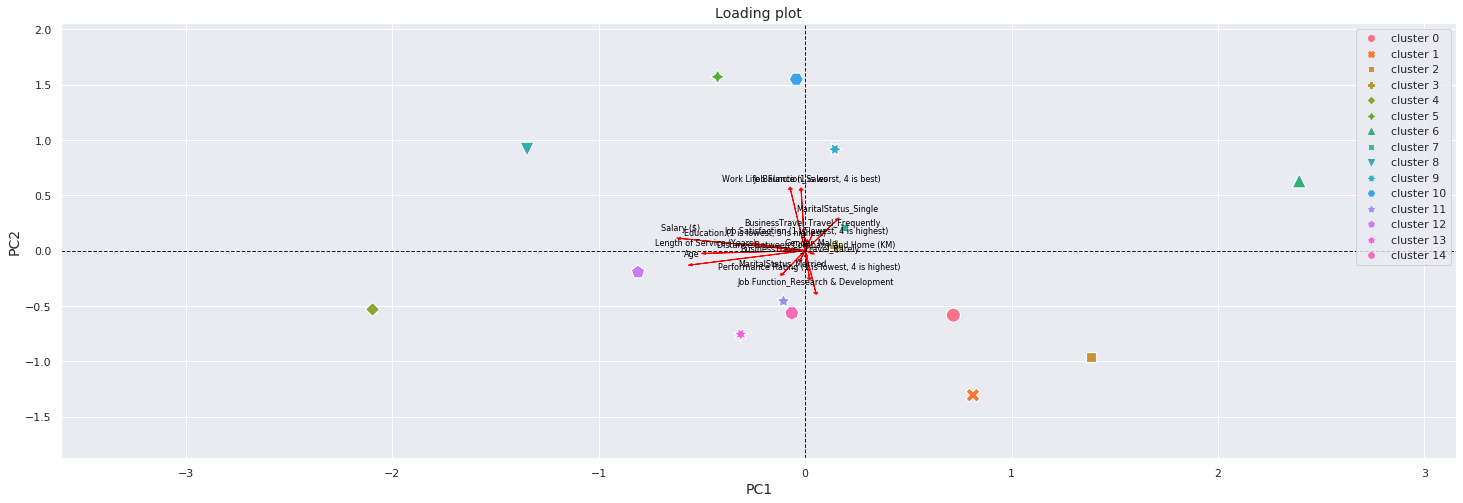

In [749]:
display(pca_results[:2].drop(['Eigenvalue', 'Explained Variance', 'Cumulative Explained Variance'], axis=1))

loadingplot(processed_df.columns, pca, 0, 1, width=25, height=8, xmargin=3, ymargin=1.5)
sns.scatterplot(x=model.cluster_centers_[:,0], y=model.cluster_centers_[:,1], s=200, style=[f'cluster {n}' for n in range(n_clusters)], hue=[f'cluster {n}' for n in range(n_clusters)])
plt.show()

,Age,Distance Between Company and Home (KM),"Education (1 is lowest, 5 is highest)","Job Satisfaction (1 is lowest, 4 is highest)",Salary ($),"Performance Rating (1 is lowest, 4 is highest)","Work Life Balance (1 is worst, 4 is best)",Length of Service (Years),Gender_Male,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Job Function_Research & Development,Job Function_Sales,MaritalStatus_Married,MaritalStatus_Single
PC 3,0.0659,-0.3938,-0.0579,0.5291,0.0338,0.2990,-0.0555,0.1165,-0.0044,0.5263,-0.2753,0.1151,-0.1600,-0.1594,0.1816
PC 4,-0.1727,0.2681,-0.6043,0.0356,0.0657,0.4528,0.1992,0.2353,-0.0004,0.0785,-0.0423,-0.1306,0.1866,0.2640,-0.3130


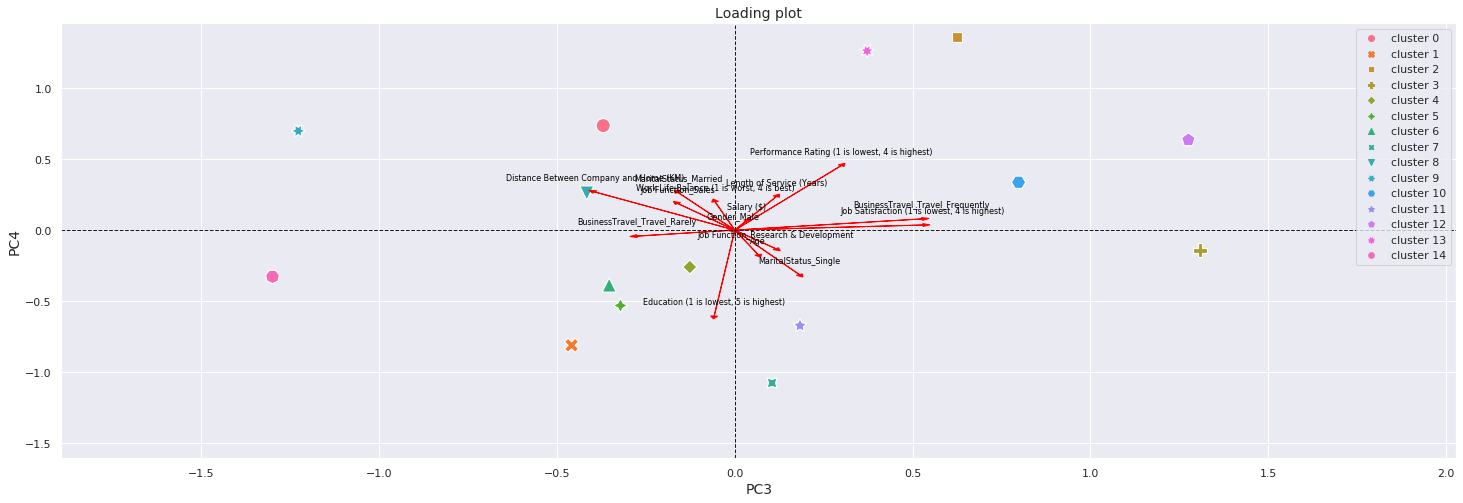

In [750]:
display(pca_results[2:4].drop(['Eigenvalue', 'Explained Variance', 'Cumulative Explained Variance'], axis=1))

loadingplot(processed_df.columns, pca, 2, 3, width=25, height=8, xmargin=1.5, ymargin=1)
sns.scatterplot(x=model.cluster_centers_[:,2], y=model.cluster_centers_[:,3], s=200, style=[f'cluster {n}' for n in range(n_clusters)], hue=[f'cluster {n}' for n in range(n_clusters)])
plt.show()

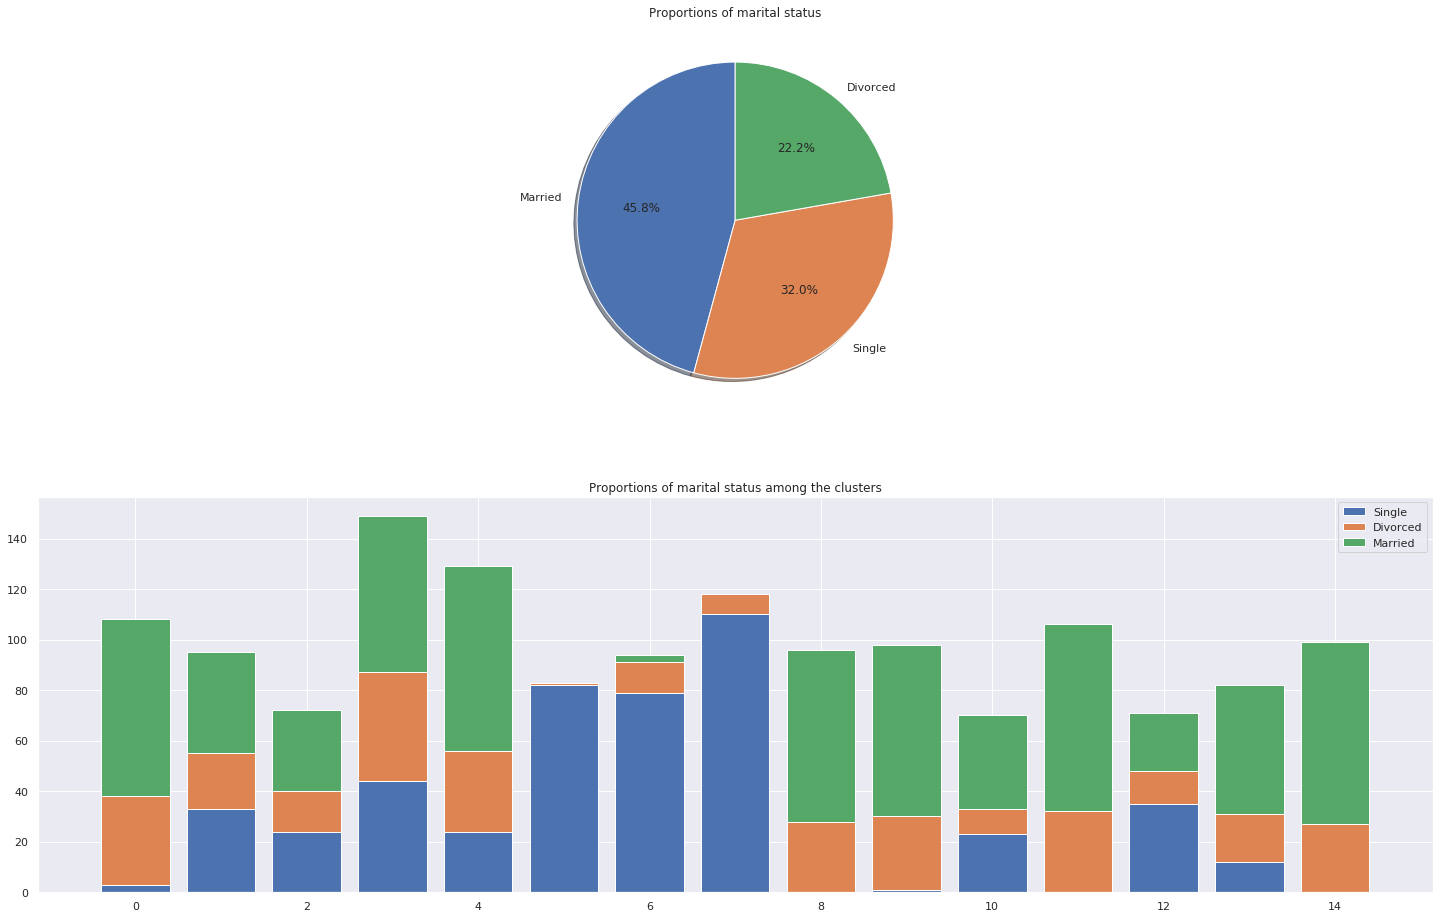

In [856]:
sns.set(rc={'figure.figsize':(25,16)})

maritalstatus = df.groupby(['labels'])['MaritalStatus'].value_counts().unstack().fillna(0)
clusters = maritalstatus.index

divorced = maritalstatus['Divorced'].values
single = maritalstatus['Single'].values
married = maritalstatus['Married'].values

fig, ax = plt.subplots(2,1)

ax[1].bar(clusters, single, label='Single')
ax[1].bar(clusters, divorced, label='Divorced', bottom=single)
ax[1].bar(clusters, married, label='Married', bottom=single+divorced)

ax[1].set_title('Proportions of marital status among the clusters')
ax[1].legend()

marital_total = df['MaritalStatus'].value_counts().values
marital = df['MaritalStatus'].value_counts().index

ax[0].pie(marital_total, labels=marital, autopct='%1.1f%%', shadow=True, startangle=90)
ax[0].set_title('Proportions of marital status')

plt.show()

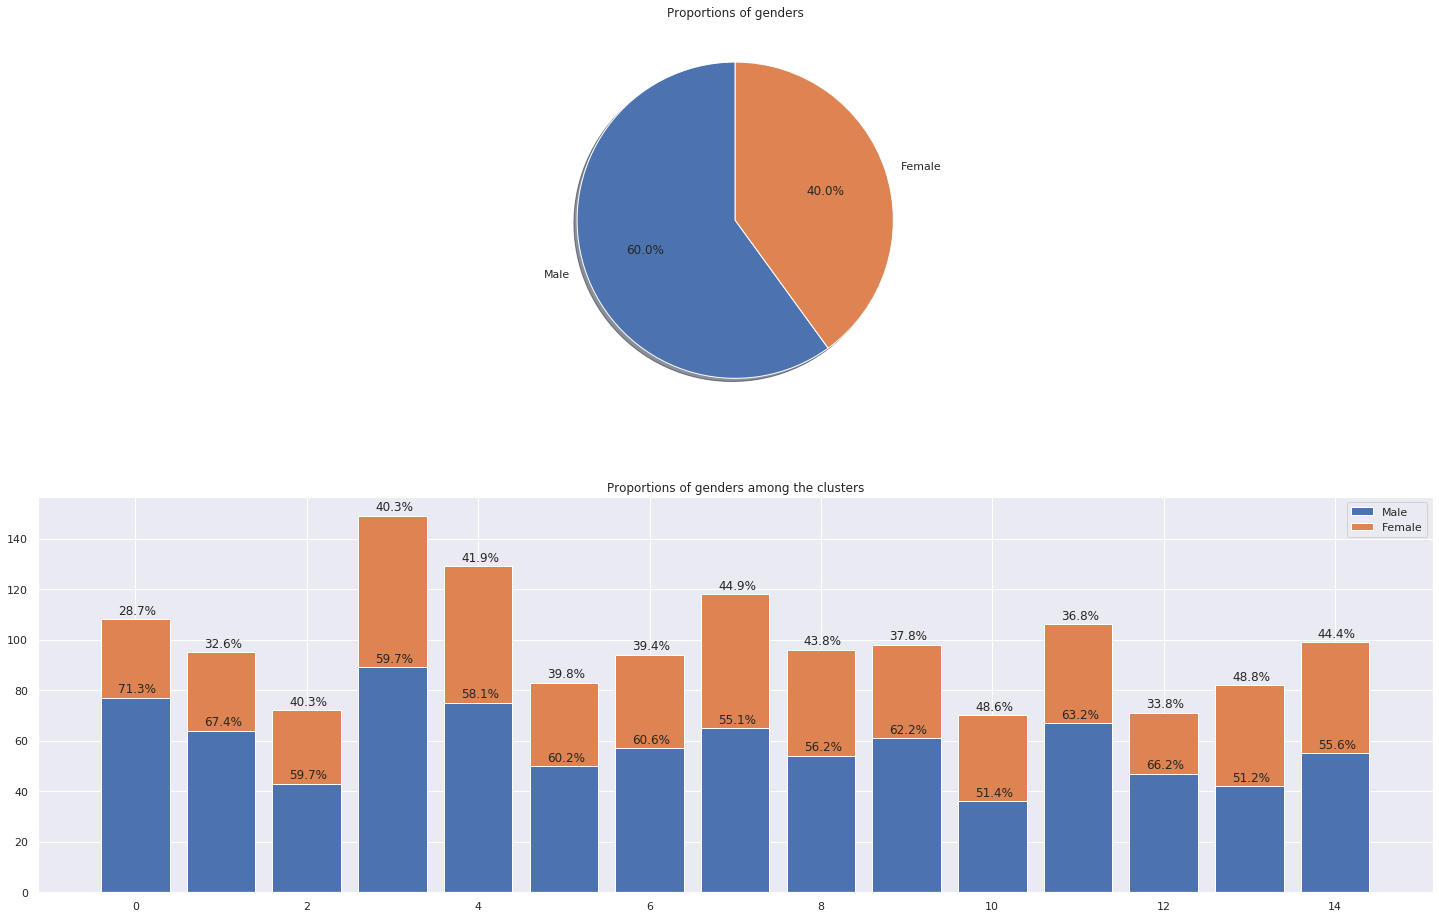

In [848]:
sns.set(rc={'figure.figsize':(25,16)})

genders = df.groupby(['labels'])['Gender'].value_counts().unstack().fillna(0)
genders_prop = df.groupby(['labels'])['Gender'].value_counts(normalize=True).unstack().fillna(0)
clusters = genders.index

male = genders['Male'].values
male_prop = genders_prop['Male'].values
female = genders['Female'].values
female_prop = genders_prop['Female'].values

fig, ax = plt.subplots(2,1)
ax[1].bar(clusters, male, label='Male')
ax[1].bar(clusters, female, label='Female', bottom=male)

for i, v in enumerate(male):
    ax[1].text(i-0.2, v+2, f'{male_prop[i]*100:0.1f}%')

for i, v in enumerate(female):
    ax[1].text(i-0.2, v+male[i]+2, f'{female_prop[i]*100:0.1f}%')

ax[1].set_title('Proportions of genders among the clusters')
ax[1].legend()

gender_total = df['Gender'].value_counts().values
genders = df['Gender'].value_counts().index

ax[0].pie(gender_total, labels=genders, autopct='%1.1f%%', shadow=True, startangle=90)
ax[0].set_title('Proportions of genders')

plt.show()

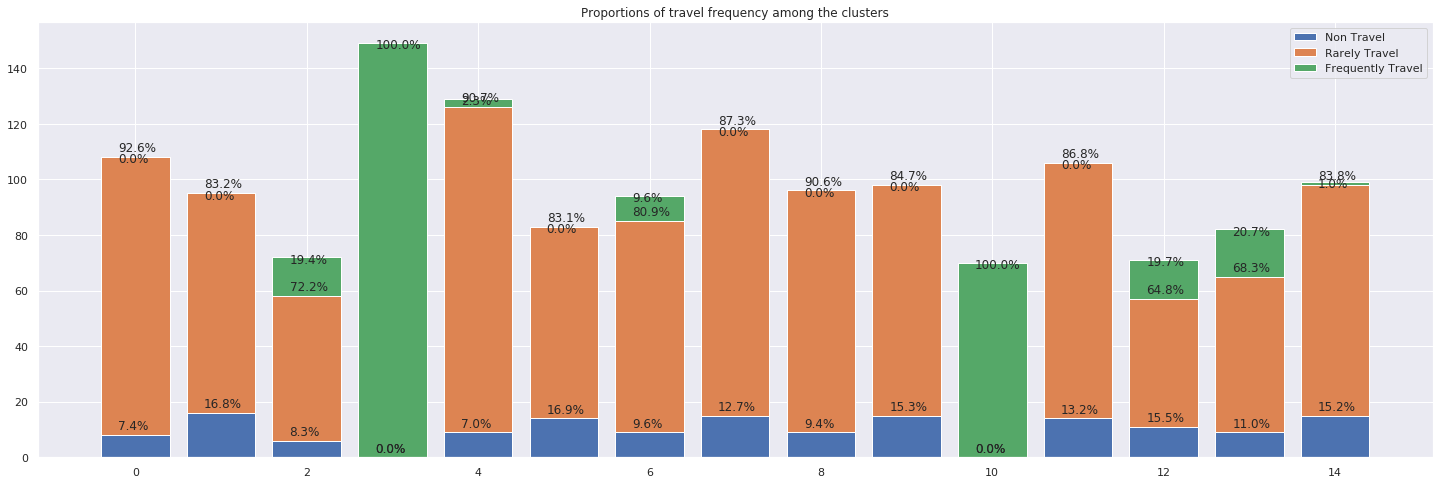

In [870]:
sns.set(rc={'figure.figsize':(25,8)})

travel = df.groupby(['labels'])['BusinessTravel'].value_counts().unstack().fillna(0)
travel_prop = df.groupby(['labels'])['BusinessTravel'].value_counts(normalize=True).unstack().fillna(0)
clusters = travel.index

nontravel = travel['Non-Travel'].values
nontravel_prop = travel_prop['Non-Travel'].values
rarelytravel = travel['Travel_Rarely'].values
rarelytravel_prop = travel_prop['Travel_Rarely'].values
freqtravel = travel['Travel_Frequently'].values
freqtravel_prop = travel_prop['Travel_Frequently'].values

fig, ax = plt.subplots()
ax.bar(clusters, nontravel, label='Non Travel')
ax.bar(clusters, rarelytravel, label='Rarely Travel', bottom=nontravel)
ax.bar(clusters, freqtravel, label='Frequently Travel', bottom=nontravel+rarelytravel)

for i, v in enumerate(nontravel):
    ax.text(i-0.2, v+2, f'{nontravel_prop[i]*100:0.1f}%')

for i, v in enumerate(rarelytravel):
    ax.text(i-0.2, v+nontravel[i]+2, f'{rarelytravel_prop[i]*100:0.1f}%')

for i, v in enumerate(freqtravel):
    ax.text(i-0.2, v+nontravel[i]+rarelytravel[i]-2, f'{freqtravel_prop[i]*100:0.1f}%')

ax.set_title('Proportions of travel frequency among the clusters')
ax.legend()
plt.show()

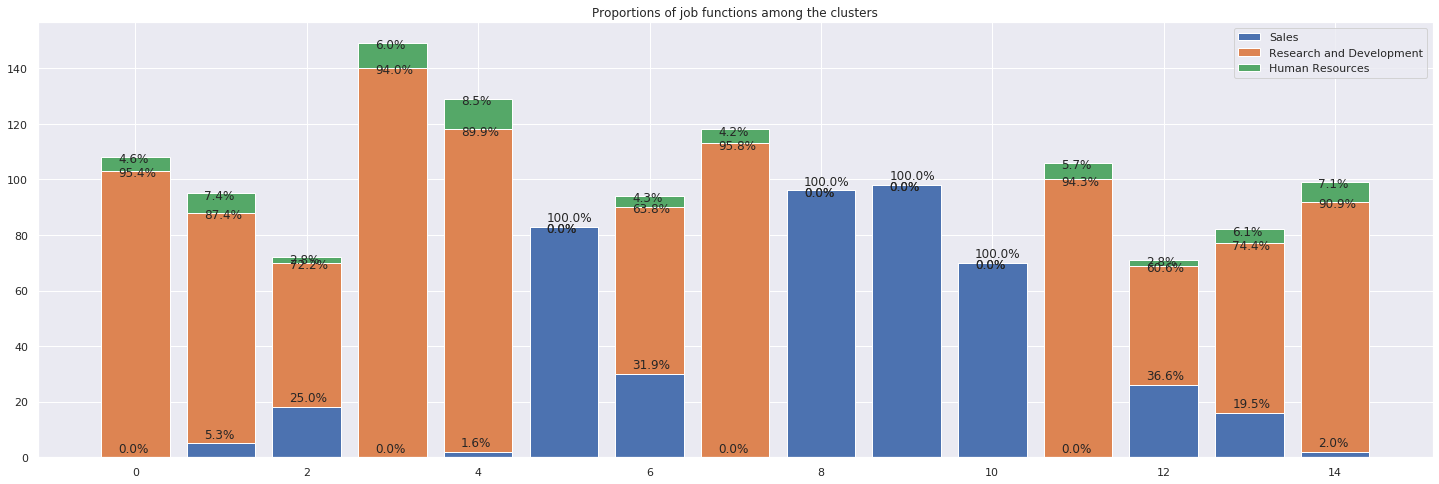

In [875]:
sns.set(rc={'figure.figsize':(25,8)})

job = df.groupby(['labels'])['Job Function'].value_counts().unstack().fillna(0)
job_prop = df.groupby(['labels'])['Job Function'].value_counts(normalize=True).unstack().fillna(0)
clusters = job.index

sales = job['Sales'].values
sales_prop = job_prop['Sales'].values
research = job['Research & Development'].values
research_prop = job_prop['Research & Development'].values
human = job['Human Resources'].values
human_prop = job_prop['Human Resources'].values

fig, ax = plt.subplots()
ax.bar(clusters, sales, label='Sales')
ax.bar(clusters, research, label='Research and Development', bottom=sales)
ax.bar(clusters, human, label='Human Resources', bottom=sales+research)

for i, v in enumerate(sales):
    ax.text(i-0.2, v+2, f'{sales_prop[i]*100:0.1f}%')

for i, v in enumerate(research):
    ax.text(i-0.2, v+sales[i]-2, f'{research_prop[i]*100:0.1f}%')

for i, v in enumerate(human):
    ax.text(i-0.2, v+sales[i]+research[i]-2, f'{human_prop[i]*100:0.1f}%')

ax.set_title('Proportions of job functions among the clusters')
ax.legend()
plt.show()

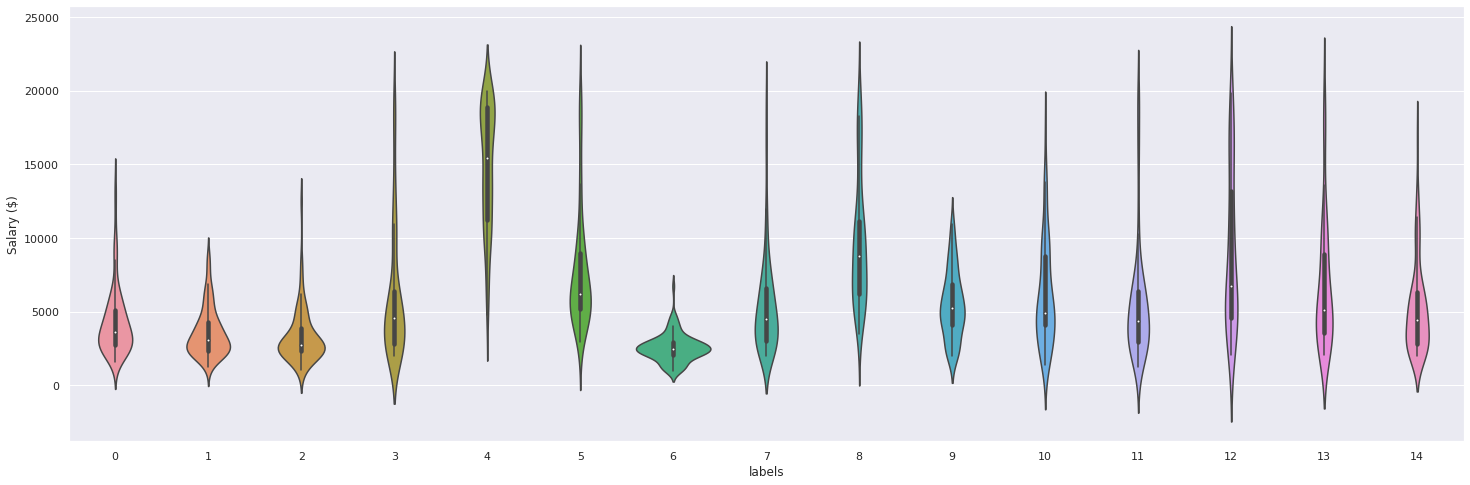

In [857]:
sns.set(rc={'figure.figsize':(25,8)})
sns.violinplot(y=df['Salary ($)'], x=df['labels'])
plt.show()

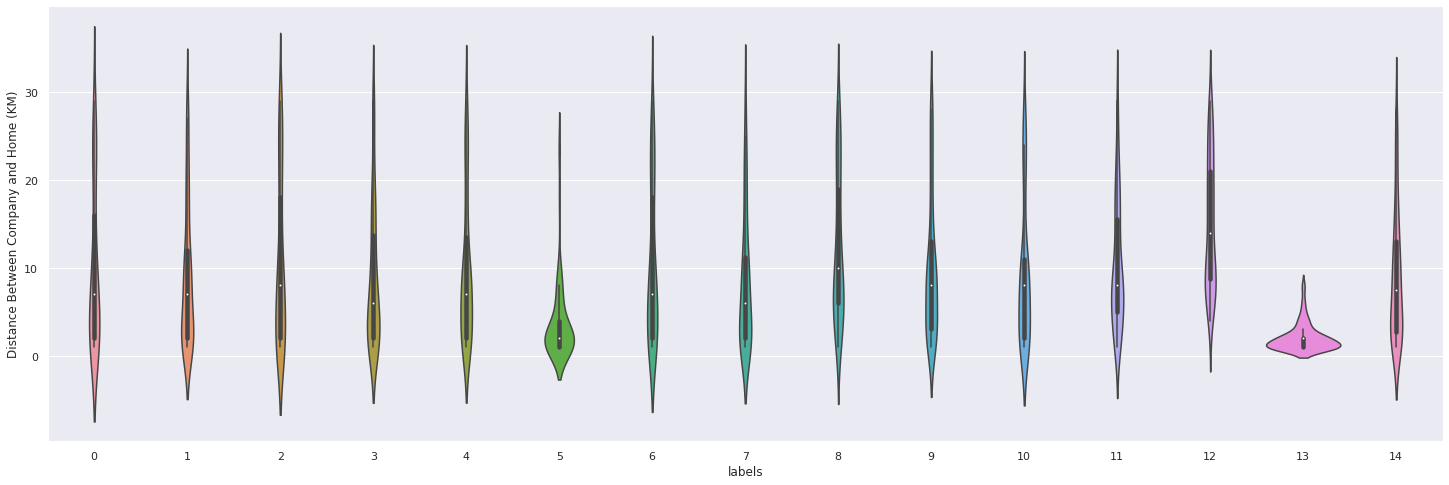

In [ ]:
sns.violinplot(y=df['Distance Between Company and Home (KM)'], x=df['labels'])

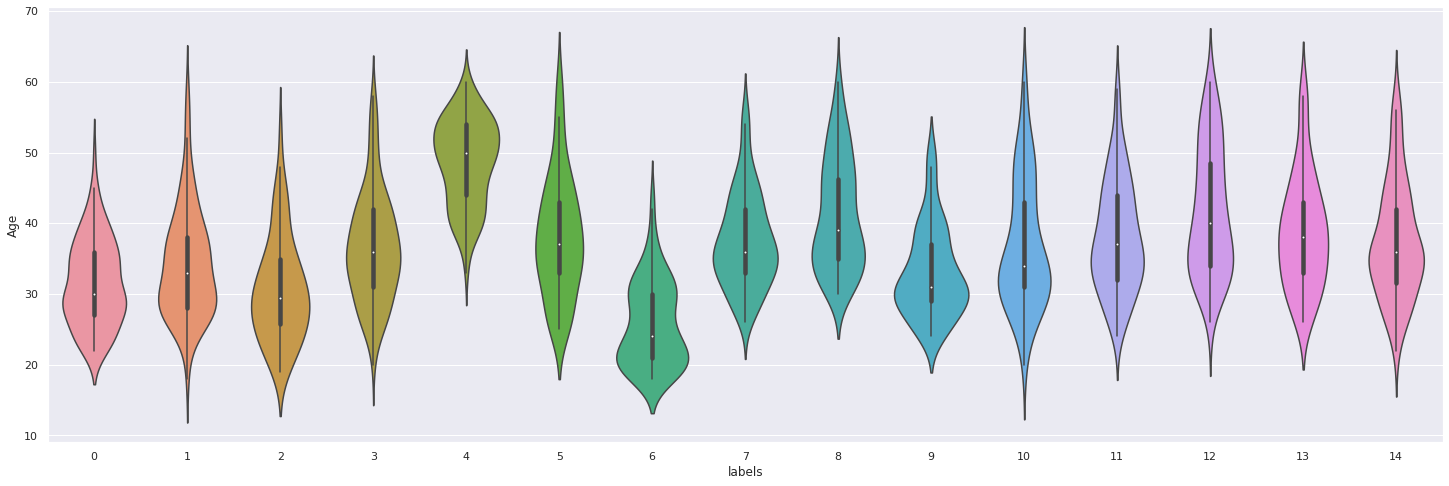

In [753]:
sns.violinplot(y=df['Age'], x=df['labels'])

In [71]:
clustering = DBSCAN(eps=2, min_samples=24).fit(FAMD_components[:,:9])
labels_dbscan = clustering.labels_
np.unique(labels_dbscan)

array([-1,  0,  1], dtype=int64)

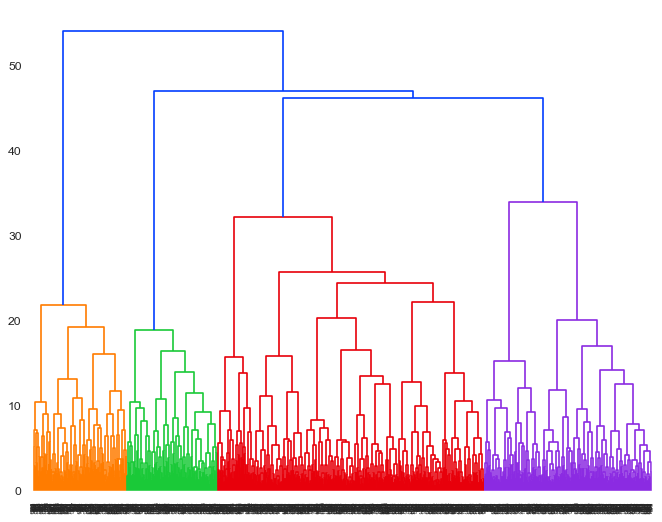

In [30]:
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(10, 8), dpi=80)

sns.set_palette('bright')

aggclustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward').fit(FAMD_components[:,:9])

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plot_dendrogram(aggclustering)

In [31]:
aggclustering = AgglomerativeClustering(n_clusters=13, linkage='ward').fit_predict(FAMD_components[:,:9])

In [32]:
df['Agg Labels'] = aggclustering

In [36]:
print(df['Resign Status'].value_counts(normalize=True))

for n in range(df['Agg Labels'].nunique()):
    total = len(df.loc[df['Agg Labels']==n])
    resigned = len(df.loc[(df['Agg Labels']==n) & (df['Resign Status']=='Yes')])

    proportion = resigned/total
    print(f'The proportion of people resigned in cluster {n}: {proportion:0.2f} (total: {total}, resigned: {resigned})')


No     0.838776
Yes    0.161224
Name: Resign Status, dtype: float64
The proportion of people resigned in cluster 0: 0.20 (total: 215, resigned: 44)
The proportion of people resigned in cluster 1: 0.13 (total: 188, resigned: 24)
The proportion of people resigned in cluster 2: 0.10 (total: 97, resigned: 10)
The proportion of people resigned in cluster 3: 0.11 (total: 150, resigned: 16)
The proportion of people resigned in cluster 4: 0.07 (total: 137, resigned: 10)
The proportion of people resigned in cluster 5: 0.41 (total: 87, resigned: 36)
The proportion of people resigned in cluster 6: 0.17 (total: 117, resigned: 20)
The proportion of people resigned in cluster 7: 0.09 (total: 99, resigned: 9)
The proportion of people resigned in cluster 8: 0.15 (total: 106, resigned: 16)
The proportion of people resigned in cluster 9: 0.22 (total: 45, resigned: 10)
The proportion of people resigned in cluster 10: 0.12 (total: 73, resigned: 9)
The proportion of people resigned in cluster 11: 0.23 (tot

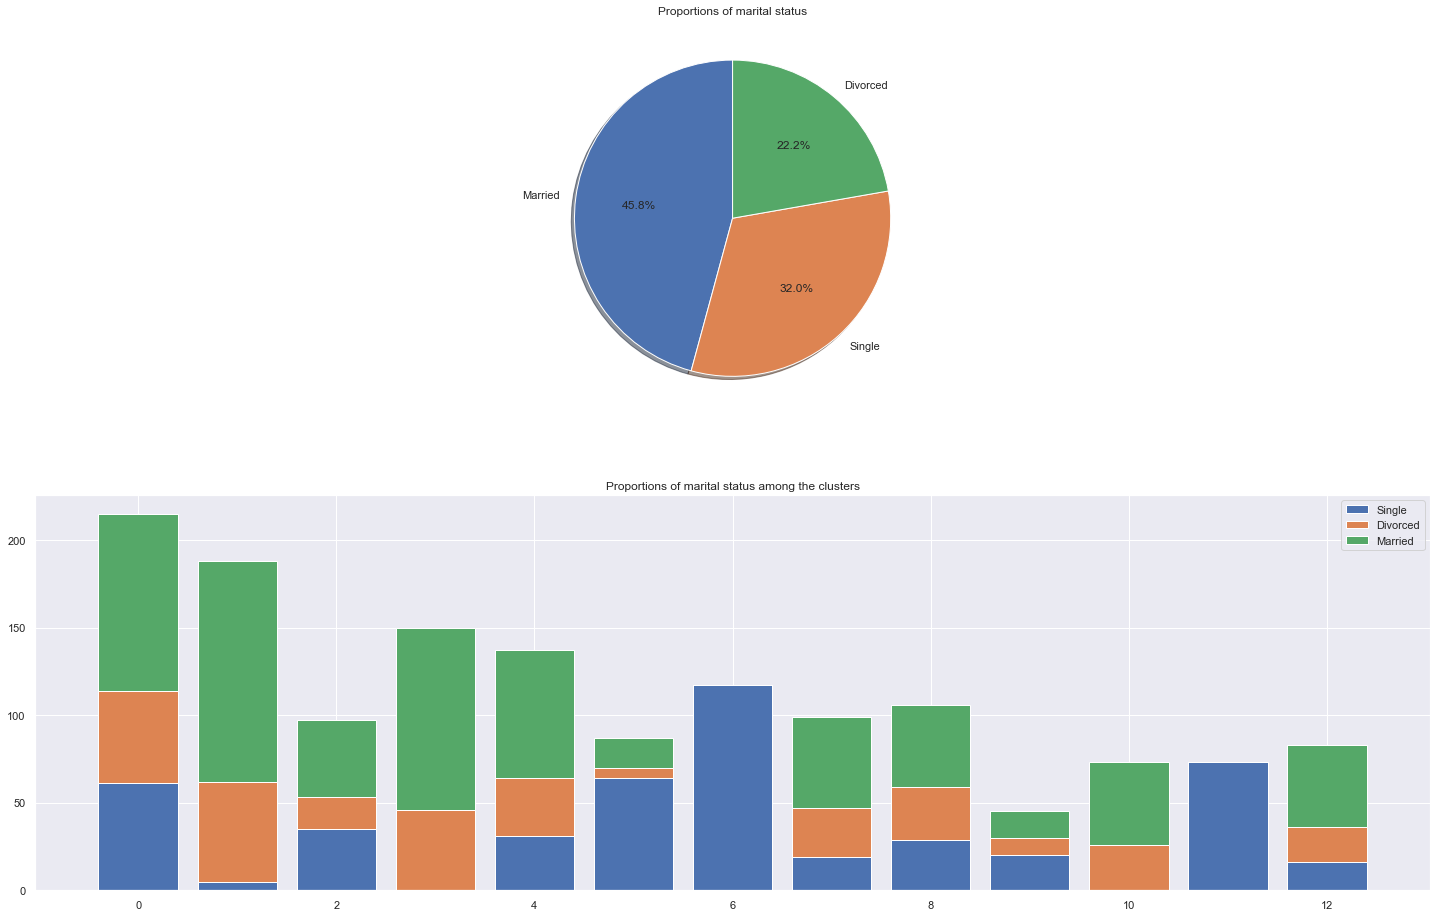

In [34]:
sns.set(rc={'figure.figsize':(25,16)})

maritalstatus = df.groupby(['Agg Labels'])['MaritalStatus'].value_counts().unstack().fillna(0)
clusters = maritalstatus.index

divorced = maritalstatus['Divorced'].values
single = maritalstatus['Single'].values
married = maritalstatus['Married'].values

fig, ax = plt.subplots(2,1)

ax[1].bar(clusters, single, label='Single')
ax[1].bar(clusters, divorced, label='Divorced', bottom=single)
ax[1].bar(clusters, married, label='Married', bottom=single+divorced)

ax[1].set_title('Proportions of marital status among the clusters')
ax[1].legend()

marital_total = df['MaritalStatus'].value_counts().values
marital = df['MaritalStatus'].value_counts().index

ax[0].pie(marital_total, labels=marital, autopct='%1.1f%%', shadow=True, startangle=90)
ax[0].set_title('Proportions of marital status')

plt.show()

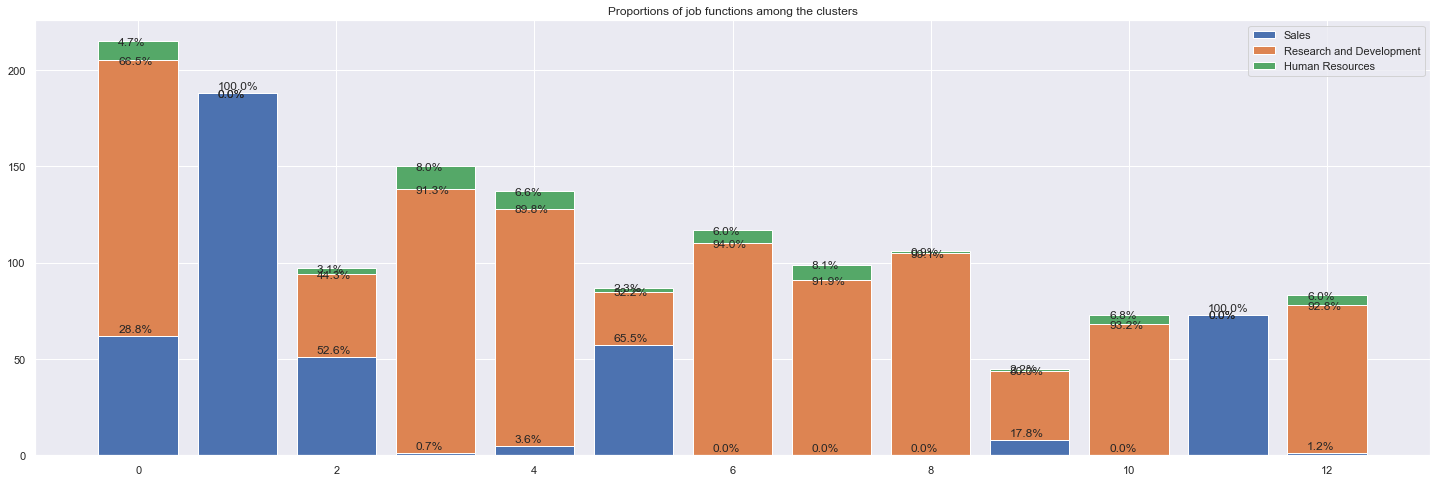

In [40]:
sns.set(rc={'figure.figsize':(25,8)})

job = df.groupby(['Agg Labels'])['Job Function'].value_counts().unstack().fillna(0)
job_prop = df.groupby(['Agg Labels'])['Job Function'].value_counts(normalize=True).unstack().fillna(0)
clusters = job.index

sales = job['Sales'].values
sales_prop = job_prop['Sales'].values
research = job['Research & Development'].values
research_prop = job_prop['Research & Development'].values
human = job['Human Resources'].values
human_prop = job_prop['Human Resources'].values

fig, ax = plt.subplots()
ax.bar(clusters, sales, label='Sales')
ax.bar(clusters, research, label='Research and Development', bottom=sales)
ax.bar(clusters, human, label='Human Resources', bottom=sales+research)

for i, v in enumerate(sales):
    ax.text(i-0.2, v+2, f'{sales_prop[i]*100:0.1f}%')

for i, v in enumerate(research):
    ax.text(i-0.2, v+sales[i]-2, f'{research_prop[i]*100:0.1f}%')

for i, v in enumerate(human):
    ax.text(i-0.2, v+sales[i]+research[i]-2, f'{human_prop[i]*100:0.1f}%')

ax.set_title('Proportions of job functions among the clusters')
ax.legend()
plt.show()

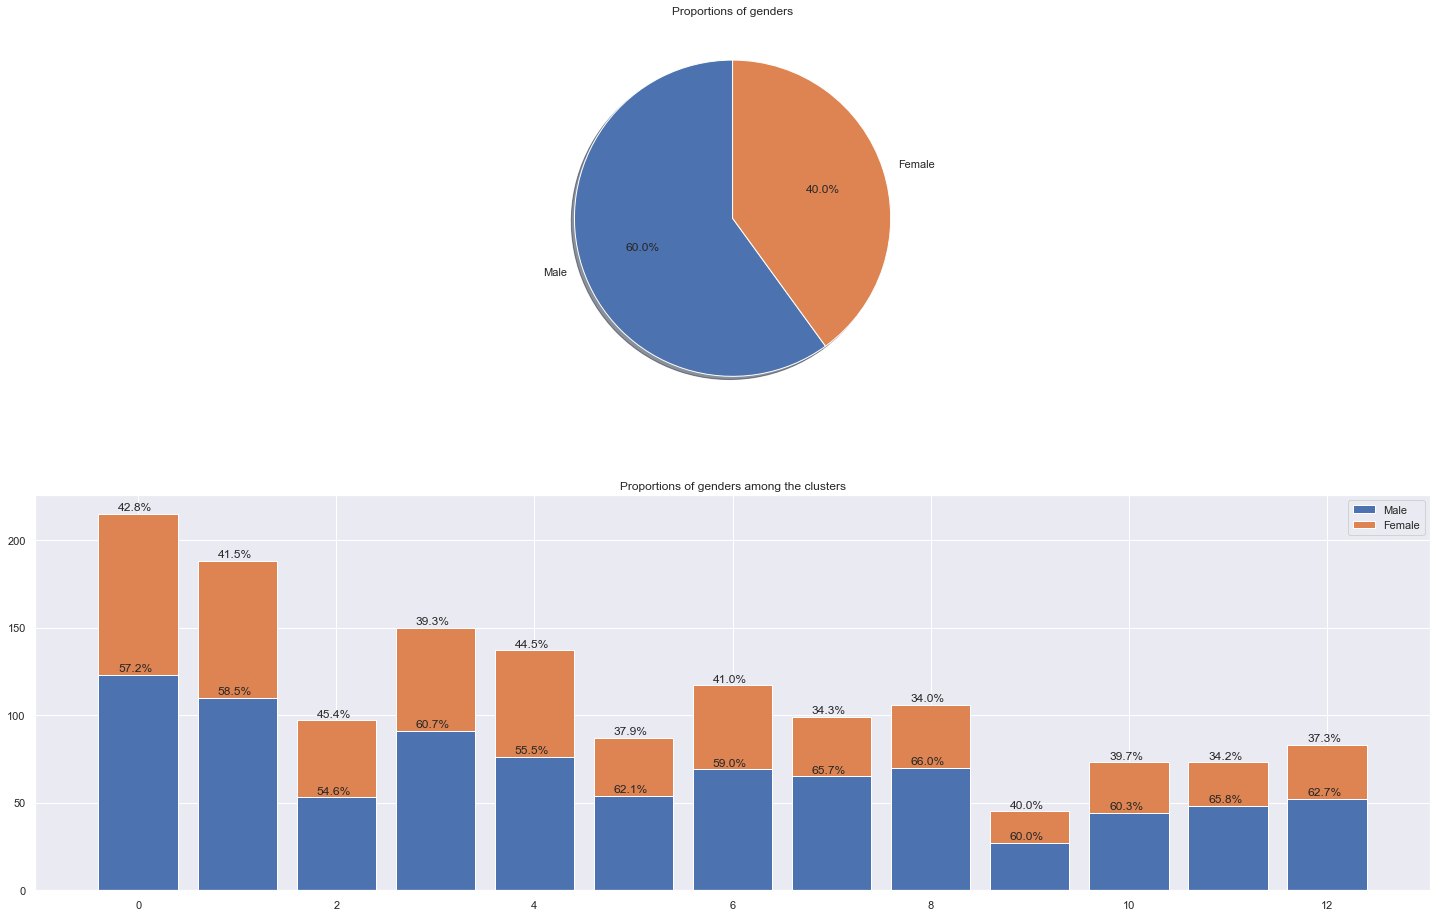

In [39]:
sns.set(rc={'figure.figsize':(25,16)})

genders = df.groupby(['Agg Labels'])['Gender'].value_counts().unstack().fillna(0)
genders_prop = df.groupby(['Agg Labels'])['Gender'].value_counts(normalize=True).unstack().fillna(0)
clusters = genders.index

male = genders['Male'].values
male_prop = genders_prop['Male'].values
female = genders['Female'].values
female_prop = genders_prop['Female'].values

fig, ax = plt.subplots(2,1)
ax[1].bar(clusters, male, label='Male')
ax[1].bar(clusters, female, label='Female', bottom=male)

for i, v in enumerate(male):
    ax[1].text(i-0.2, v+2, f'{male_prop[i]*100:0.1f}%')

for i, v in enumerate(female):
    ax[1].text(i-0.2, v+male[i]+2, f'{female_prop[i]*100:0.1f}%')

ax[1].set_title('Proportions of genders among the clusters')
ax[1].legend()

gender_total = df['Gender'].value_counts().values
genders = df['Gender'].value_counts().index

ax[0].pie(gender_total, labels=genders, autopct='%1.1f%%', shadow=True, startangle=90)
ax[0].set_title('Proportions of genders')

plt.show()

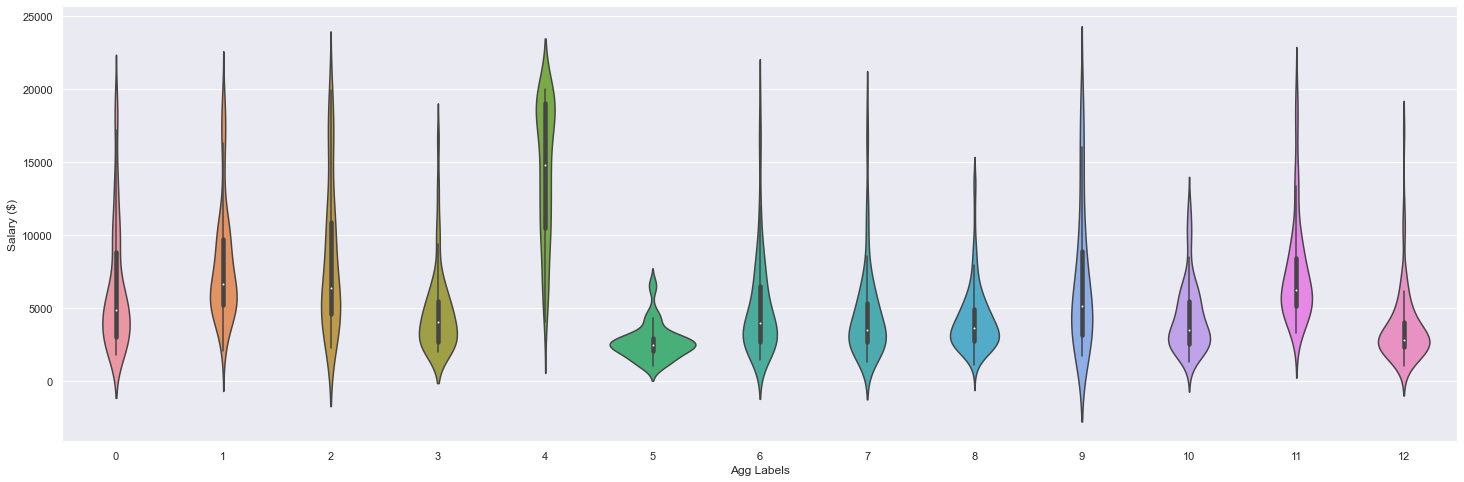

In [37]:
sns.set(rc={'figure.figsize':(25,8)})
sns.violinplot(y=df['Salary ($)'], x=df['Agg Labels'])
plt.show()

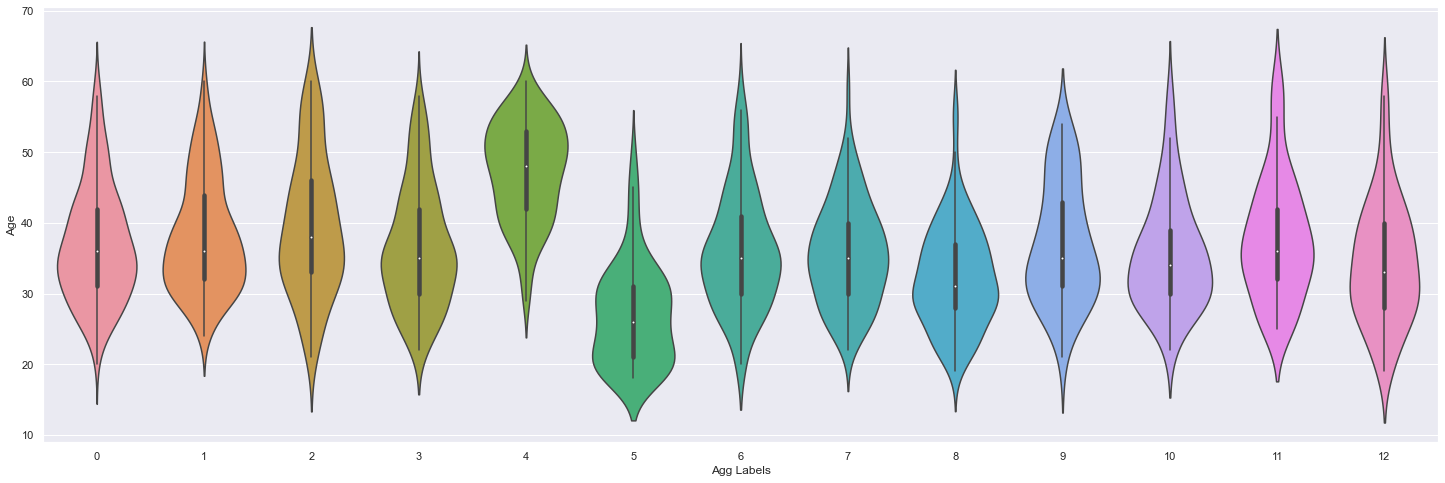

In [42]:
sns.violinplot(y=df['Age'], x=df['Agg Labels'])
plt.show()

In [ ]:
dbclustering = DBSCAN()